In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import LassoCV, Lasso

from math import sqrt

import seaborn as sns


np.set_printoptions(suppress=True, precision=4)

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/abulbasar/data/master/startups.csv")
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
R&D Spend          50 non-null float64
Administration     50 non-null float64
Marketing Spend    50 non-null float64
State              50 non-null object
Profit             50 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.0+ KB


There are 50 observations and 5 columns. 4 columns - R&D Spend, Administration and Marketing Spend, and Profile are numeric and one is categorical - State. There is no null values in the dataset. 

Let's see the distribution of the Profit using a histogram plot and see if there is any outliers in the data using bosplot.

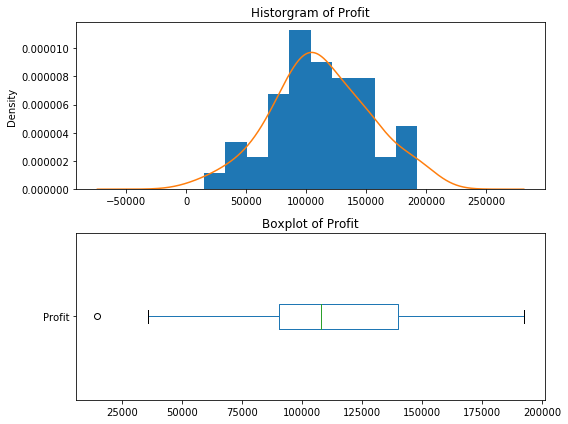

In [15]:
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
df.Profit.plot.hist(bins = 10, normed = True)
df.Profit.plot.kde(title = "Historgram of Profit")

plt.subplot(2, 1, 2)
df.Profit.plot.box(vert = False, title = "Boxplot of Profit")

plt.tight_layout()

Profit has one outlier. We can try to take log scale to remove the outlier value before doing any prediction. But for now, let ignore the outlier.

Let's plot association between each pair of columns. 

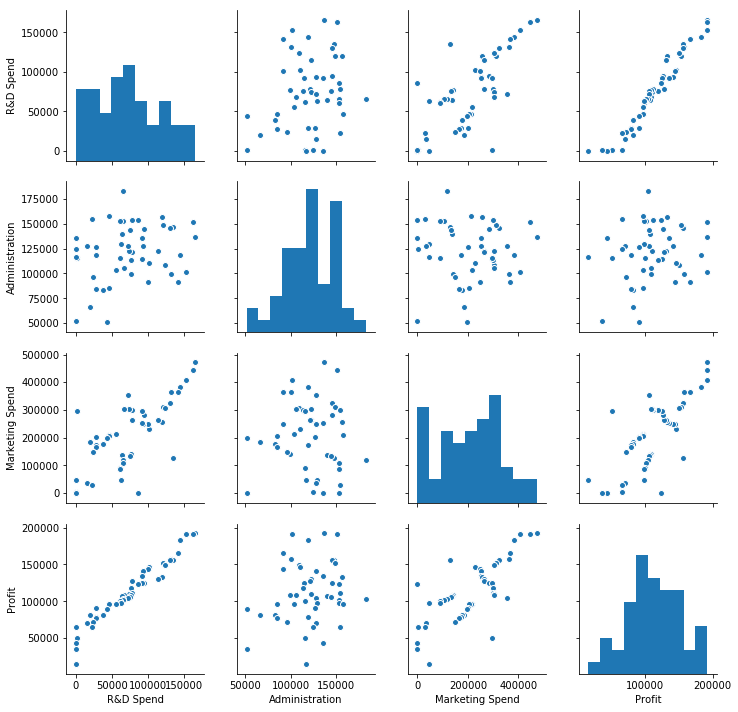

In [18]:
sns.pairplot(df)

Displays only the numeric column. Let's how the avg Profit plays for each State.

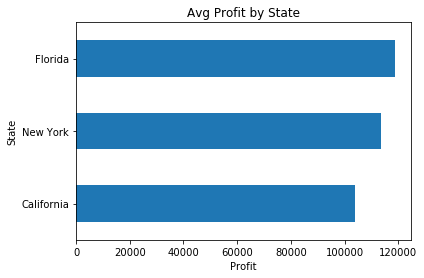

In [41]:
df.groupby("State").Profit.mean().sort_values().plot.barh(title = "Avg Profit by State")
plt.xlabel("Profit")

Avg Profit is highest in state of Florida and least in California.

Let's create the y vector containing the outcome column.

In [50]:
y = df.Profit.values
y

array([ 192261.83,  191792.06,  191050.39,  182901.99,  166187.94,
        156991.12,  156122.51,  155752.6 ,  152211.77,  149759.96,
        146121.95,  144259.4 ,  141585.52,  134307.35,  132602.65,
        129917.04,  126992.93,  125370.37,  124266.9 ,  122776.86,
        118474.03,  111313.02,  110352.25,  108733.99,  108552.04,
        107404.34,  105733.54,  105008.31,  103282.38,  101004.64,
         99937.59,   97483.56,   97427.84,   96778.92,   96712.8 ,
         96479.51,   90708.19,   89949.14,   81229.06,   81005.76,
         78239.91,   77798.83,   71498.49,   69758.98,   65200.33,
         64926.08,   49490.75,   42559.73,   35673.41,   14681.4 ])

Let's create dummy variables for categorical feature.

In [57]:
df_features = df.iloc[:, 0:4]
df_dummied = pd.get_dummies(df_features, columns=["State"], drop_first=True)
df_dummied.sample(10)

,R&D Spend,Administration,Marketing Spend,State_Florida,State_New York
33,55493.95,103057.49,214634.81,1,0
1,162597.70,151377.59,443898.53,0,0
25,64664.71,139553.16,137962.62,0,0
34,46426.07,157693.92,210797.67,0,0
18,91749.16,114175.79,294919.57,1,0
23,67532.53,105751.03,304768.73,1,0
49,0.00,116983.80,45173.06,0,0
13,91992.39,135495.07,252664.93,0,0
6,134615.46,147198.87,127716.82,0,0
15,114523.61,122616.84,261776.23,0,1


State column has been replaced by two additional column - one for Florida and one NY. First value in the categorical values CA has been dropped to avoid collinearity issue.

Now, let's create X feature matrix and y outcome vector.  

In [104]:
X = df_dummied.values
X[0, :]

array([ 165349.2,  136897.8,  471784.1,       0. ,       1. ])

Let's normalize the feature values to bring them to a similar scale.

In [115]:
scaler = StandardScaler() 
X_std = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4
0,165349.20,136897.80,471784.10,0.0,1.0
1,162597.70,151377.59,443898.53,0.0,0.0
2,153441.51,101145.55,407934.54,1.0,0.0
3,144372.41,118671.85,383199.62,0.0,1.0
4,142107.34,91391.77,366168.42,1.0,0.0


Split the X and y into training and test sets.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.3, random_state = 100)

In [107]:
print("Training set: ", X_train.shape, y_train.shape)

Training set:  (35, 5) (35,)


In [108]:
print("Test set: ", X_test.shape, y_test.shape)

Test set:  (15, 5) (15,)


Ratio of the size of the training data

In [109]:
X_train.shape[0] / df.shape[0]

0.7

Fit linear regression model

In [110]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [111]:
lr.intercept_, lr.coef_

(111442.18784400707,
 array([ 38209.9736,   -775.0259,   2756.1079,  -1532.2616,  -2506.5352]))

By looking at the cofficients, we can conclude that R&D Spend has the higest influence on the outcome variable.

Predict the outcome based on the model

In [112]:
y_test_pred = lr.predict(X_test)

In [113]:
output = pd.DataFrame({"actual": y_test, "prediction": y_test_pred})
output["error"] = output.actual - output.prediction
output

,actual,prediction,error
0,156122.51,162877.200905,-6754.690905
1,90708.19,72734.781061,17973.408939
2,89949.14,90998.192353,-1049.052353
3,103282.38,100730.655548,2551.724452
4,69758.98,55884.994373,13873.985627
5,14681.40,48647.970829,-33966.570829
6,156991.12,161960.522158,-4969.402158
7,96778.92,96273.641001,505.278999
8,118474.03,118625.800514,-151.770514
9,71498.49,71449.009873,49.480127


A simpliest prediction model could have been the average. Let's how the model did overall against one feature.

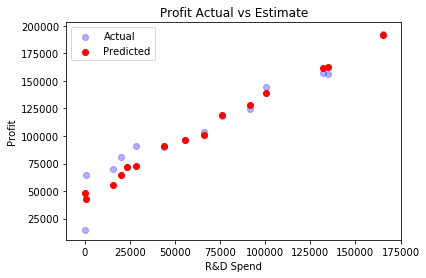

In [119]:
X_test_inv = scaler.inverse_transform(X_test)
plt.scatter(X_test_inv[:, 0], y_test, alpha = 0.3, c = "blue", label = "Actual")
plt.scatter(X_test_inv[:, 0], y_test_pred, c = "red", label = "Predicted")

plt.xlabel("R&D Spend")
plt.ylabel("Profit")
plt.title("Profit Actual vs Estimate")
plt.legend()

In [132]:
np.mean((y_test_pred - y_test) ** 2)

169303616.12869918

In [134]:
y_train_pred = lr.predict(X_train)

Compare the root mean squared error (RMSE) of test dataset against the training.

In [140]:
sqrt(mean_squared_error(y_test, y_test_pred)), sqrt(mean_squared_error(y_train, y_train_pred))

(13011.672303309026, 6945.630255385447)

r2 score can have a max value 1, negative values of R2 means suboptimal model 

In [143]:
r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)

(0.91000648598133016, 0.96645583180478356)

On the training the both RMSE and R2 scores perform natually better than those on the test dataset.

# Power Plant Dataset
Let's look at another dataset

In [103]:
df = pd.read_csv("data/Combined_Cycle_Power_Plant.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [104]:
X = df.iloc[:, 0:4].values
y = df.PE.values

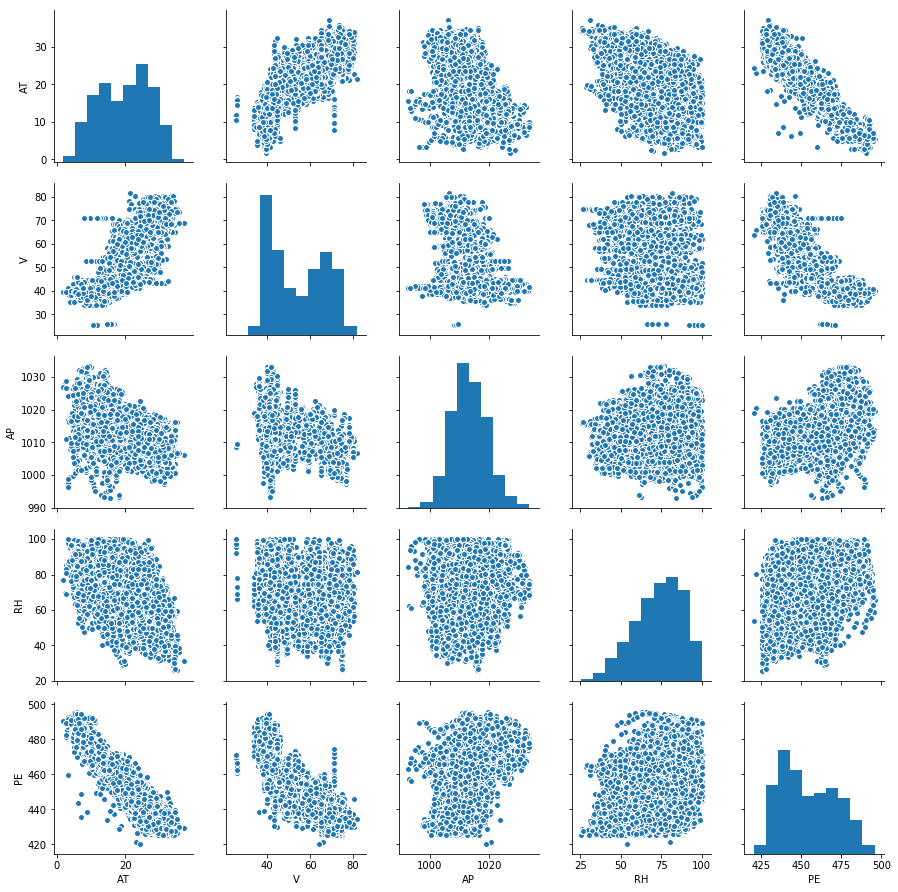

In [105]:
sns.pairplot(df)

In [106]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 100)

In [108]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [109]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
rmse(y_test, y_test_pred)

4.574907794113806

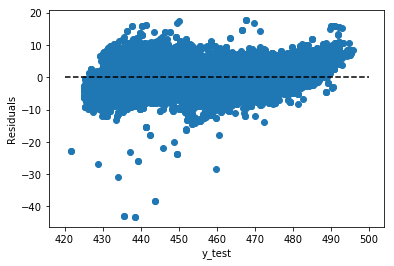

In [110]:
plt.scatter(y_test, y_test - y_test_pred)
plt.xlabel("y_test")
plt.ylabel("Residuals")
plt.hlines([0], xmin = 420, xmax = 500, linestyles = "dashed")

In [111]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print("Dim of X_train_poly", X_train_poly.shape)
pd.DataFrame(X_test_poly).head()

Dim of X_train_poly (33488, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,0.391651,0.636976,-0.587538,0.872702,0.153391,0.249472,-0.230110,0.341795,0.405738,...,0.258445,-0.238386,0.354089,0.219885,-0.326607,0.485127,-0.202819,0.301258,-0.447474,0.664658
1,1.0,0.799599,0.358394,0.107927,-1.260932,0.639358,0.286571,0.086298,-1.008239,0.128446,...,0.046034,0.013863,-0.161962,0.004175,-0.048773,0.569828,0.001257,-0.014688,0.171598,-2.004816
2,1.0,-0.045819,-0.124795,1.965307,-1.327372,0.002099,0.005718,-0.090048,0.060819,0.015574,...,-0.001944,0.030607,-0.020672,-0.482014,0.325553,-0.219879,7.590861,-5.126883,3.462707,-2.338720
3,1.0,1.721507,1.226404,0.121399,-1.843828,2.963585,2.111263,0.208988,-3.174162,1.504067,...,1.844593,0.182591,-2.773240,0.018074,-0.274516,4.169408,0.001789,-0.027174,0.412719,-6.268465
4,1.0,-1.084475,-1.017201,1.423080,-0.809546,1.176086,1.103129,-1.543295,0.877933,1.034698,...,-1.052495,1.472457,-0.837636,-2.059991,1.171865,-0.666638,2.881959,-1.639458,0.932637,-0.530549


In [112]:
lr.fit(X_train_poly, y_train)
y_test_pred = lr.predict(X_test_poly)
print("rmse:", rmse(y_test, y_test_pred))
lr.coef_

rmse: 4.172714790148154


array([  0.    , -13.1634,  -4.9193,   2.1675,  -1.5073,   1.5778,
         0.538 ,  -0.2714,  -0.3938,  -0.4908,   0.3258,  -0.2125,
        -0.5775,  -0.5861,  -0.4467,   0.2405,   0.946 ,   0.1634,
        -0.7727,  -1.611 ,  -0.5325,   1.5694,  -0.2774,  -0.6071,
        -0.6189,   1.0729,  -0.876 ,  -0.6998,  -0.1251,   0.3107,
         0.3166,  -0.1195,  -0.1784,  -0.4407,  -0.1735])

In [113]:
lasso = Lasso(alpha=0.03, max_iter=10000, normalize=False, random_state=100)
lasso.fit(X_train_poly, y_train)
y_test_pred = lasso.predict(X_test_poly)
print("rmse:", rmse(y_test, y_test_pred))
lasso.coef_

rmse: 4.202132122245518


array([  0.    , -13.578 ,  -4.2909,   1.7077,  -1.5637,   1.6903,
         0.    ,   0.    ,  -0.096 ,  -0.0239,   0.1611,  -0.3158,
        -0.4337,  -0.3128,  -0.306 ,   0.266 ,   0.    ,   0.1263,
         0.    ,  -0.    ,  -0.4512,   0.0136,  -0.2302,  -0.    ,
        -0.0254,   0.2787,  -0.4845,   0.    ,  -0.0111,   0.    ,
        -0.1324,  -0.0896,  -0.0463,  -0.1242,  -0.0593])

Let's find cross validation score that accuracy score is more reliable in a sense that it incorporates every piece of is incorporated in both training and testing.

In [122]:
lasso = Lasso(alpha=0.03, max_iter=10000, normalize=False, random_state=100)
scores = cross_val_score(lasso, X_train_poly, y_train, cv=5, scoring="neg_mean_squared_error")
scores = np.sqrt(-scores)
scores

array([ 4.1523,  4.2153,  4.0835,  4.2522,  4.1369])

LassoCV helps find the best alpha. We could also use model tuning techqniues to find best alpha as well.

In [14]:
lassocv = LassoCV(cv = 5, max_iter=10000, tol=1e-5, normalize=False)
lassocv.fit(X_train_poly, y_train)
print("Lassocv alpha: ", lassocv.alpha_)
lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000, normalize=False, random_state=100)
lasso.fit(X_train_poly, y_train)
y_test_pred = lasso.predict(X_test_poly)
print("rmse:", rmse(y_test, y_test_pred))

Lassocv alpha:  0.0307855534344
rmse: 4.202974440113335


Look at the cofficients values. Many of the features are not zero making the model parsimonious hence more robust - that is less prone to overfitting.

In [15]:
lasso.coef_

array([  0.    , -13.566 ,  -4.2874,   1.7045,  -1.5552,   1.6841,
         0.    ,   0.    ,  -0.0964,  -0.0152,   0.161 ,  -0.314 ,
        -0.4315,  -0.3099,  -0.3039,   0.2581,   0.    ,   0.1127,
         0.    ,  -0.    ,  -0.4349,   0.0026,  -0.2323,  -0.    ,
        -0.021 ,   0.2745,  -0.4853,   0.    ,  -0.0072,   0.    ,
        -0.137 ,  -0.0892,  -0.0452,  -0.1205,  -0.0583])

Let's plot how coefficient reached 0 values by varying the alpha valuess.

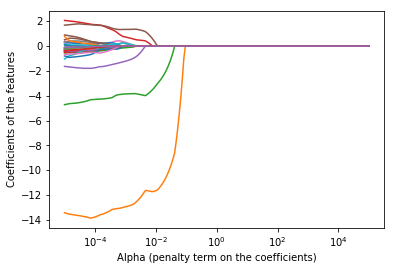

In [17]:
coefs = []
alphas = 10 ** np.linspace(-5, 5, 200)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-5,
                  normalize=True, random_state=100)
    lasso.fit(X_train_poly, y_train)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("Alpha (penalty term on the coefficients)")
plt.ylabel("Coefficients of the features")
    

From this graph, which alpha values should we select. That question can be answered by looking which alpha values gives the best performance (rmse for example). lassocv function does that for us, or we can use model tuning techniques using grid search - that will be explained later.

### Xgboost


In [125]:
gbm = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, 
                     silent=True, objective='reg:linear', booster='gbtree', gamma=0,
                     min_child_weight=1, max_delta_step=0, subsample=1,
                     colsample_bytree=1, colsample_bylevel=1, 
                     reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                     random_state=0)
gbm.fit(X_train_poly, y_train)
y_test_pred = gbm.predict(X_test_poly)
print("rmse:", rmse(y_test, y_test_pred))

rmse: 1.7712267887081141


[0]	eval-rmse:317.938	train-rmse:318.051
[1]	eval-rmse:222.605	train-rmse:222.663
[2]	eval-rmse:155.873	train-rmse:155.906
[3]	eval-rmse:109.169	train-rmse:109.185
[4]	eval-rmse:76.489	train-rmse:76.4953
[5]	eval-rmse:53.6323	train-rmse:53.6289
[6]	eval-rmse:37.6609	train-rmse:37.6547
[7]	eval-rmse:26.5157	train-rmse:26.5116
[8]	eval-rmse:18.7614	train-rmse:18.7648
[9]	eval-rmse:13.3915	train-rmse:13.3947
[10]	eval-rmse:9.7087	train-rmse:9.71626
[11]	eval-rmse:7.23866	train-rmse:7.25835
[12]	eval-rmse:5.61079	train-rmse:5.64405
[13]	eval-rmse:4.59131	train-rmse:4.63258
[14]	eval-rmse:3.98305	train-rmse:4.03478
[15]	eval-rmse:3.63523	train-rmse:3.69815
[16]	eval-rmse:3.41101	train-rmse:3.48659
[17]	eval-rmse:3.30205	train-rmse:3.38372
[18]	eval-rmse:3.21081	train-rmse:3.29616
[19]	eval-rmse:3.1539	train-rmse:3.24859
[20]	eval-rmse:3.09733	train-rmse:3.19731
[21]	eval-rmse:3.06126	train-rmse:3.1667
[22]	eval-rmse:3.0021	train-rmse:3.10961
[23]	eval-rmse:2.97234	train-rmse:3.08854
[24]	ev

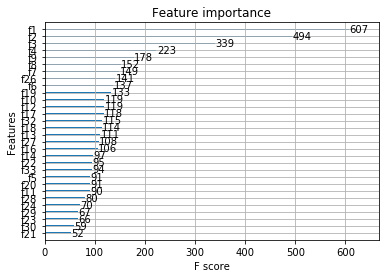

In [72]:
# change booster to gblinear, so that we are fitting a linear model
# alpha is the L1 regularizer
# lambda is the L2 regularizer
# you can also set lambda_bias which is L2 regularizer on the bias term
param = {'silent':1, 
         'objective':'reg:linear', 
         'booster':'gbtree',
         'alpha': 0.0001, 
         'lambda': 1
        }

dtrain = xgb.DMatrix(X_train_poly, label=y_train)
dtest = xgb.DMatrix(X_test_poly, label=y_test)
watchlist  = [(dtrain,'eval'), (dtest, 'train')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, watchlist, verbose_eval=True)
y_test_pred = bst.predict(dtest)
print("rmse:", rmse(y_test, y_test_pred))
xgb.plot_importance(bst)

# Exercise 4: Advanced Regression Problem

Use housing the data form Kaggle 

1. Apply linear regression model to predict the SalePrice. 
Use seed as 100, and build model on the nueric features alone.
report out the R2 value and MSE

2. Apply Lasso on the model on the same set of numeric features and find R2 and MSE. 
Find out which features are significant.  




In [74]:
df = pd.read_csv("data/kaggle-house-prices/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [75]:
df_numeric = df.select_dtypes([np.float64, np.int64])
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
F

In [76]:
df_numeric = df_numeric.fillna(df_numeric.median())

In [77]:
if "Id" in df_numeric.columns:
    del df_numeric["Id"]

In [78]:
X, y = df_numeric.iloc[:, :-1],  df_numeric.iloc[:, -1]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size = 0.3, random_state = 123)

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8408902412962439

In [84]:
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics as metrics
scores = cross_val_score(cv=5, estimator=LinearRegression(), 
                         scoring= metrics.make_scorer(metrics.median_absolute_error), 
                         X=X_train, y=y_train)
scores.mean()

16752.756460073586

In [85]:
lassocv = LassoCV(cv = 5, max_iter=10000, normalize=True, tol=1e-6)
lassocv.fit(X_train, y_train)
print("Features: ", lasso.coef_, "alpha: ",lassocv.alpha_
      ,  "\nR2 score: ", lassocv.score(X_test, y_test))

Features:  [ 0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0. -0. -0. -0.  0.
  0. -0.  0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.] alpha:  131.676891221 
R2 score:  0.813145915129


In [86]:
lassocv.coef_, lassocv.n_iter_

(array([   -70.7526,      0.    ,      0.1219,  20656.1364,      0.    ,
           150.3785,    204.3157,     16.6034,     11.0479,      0.    ,
            -0.    ,      6.3284,      9.6778,      0.    ,     -0.    ,
            38.4906,   2380.9356,      0.    ,      0.    ,      0.    ,
            -0.    ,     -0.    ,      0.    ,   4522.7387,      0.    ,
         11794.8155,      0.    ,     12.9732,      0.    ,     -0.    ,
             0.    ,      0.    ,     -0.    ,     -0.    ,      0.    ,
            -0.    ]), 45)

In [87]:
coefficients = pd.DataFrame({"field": df_numeric.columns[:-1], "coefficient": lassocv.coef_})
significant_fields = list(coefficients[coefficients.coefficient != 0].field)
significant_fields

['MSSubClass',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF']

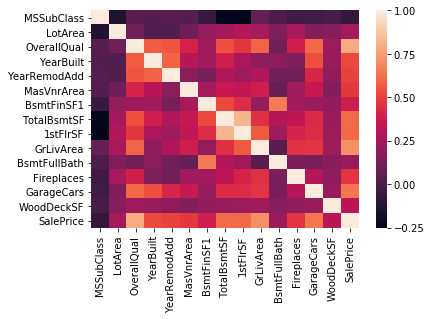

In [88]:
significant_fields.append("SalePrice")
df_mini = df[significant_fields]
sns.heatmap(df_mini.corr())

/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


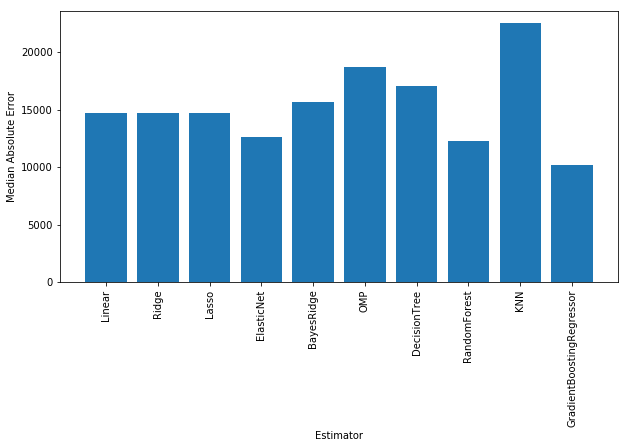

In [89]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors

rs = 1
ests = [ 
    linear_model.LinearRegression(), 
    linear_model.Ridge(),    
    linear_model.Lasso(), 
    linear_model.ElasticNet(),
    linear_model.BayesianRidge(),
    linear_model.OrthogonalMatchingPursuit(),
    tree.DecisionTreeRegressor(max_depth=10),
    ensemble.RandomForestRegressor(),
    neighbors.KNeighborsRegressor(n_neighbors=5),
    ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.01,loss="ls")
]

ests_labels = ['Linear', 
               'Ridge', 
               'Lasso',
               'ElasticNet',
               'BayesRidge',
               'OMP',
               'DecisionTree',
               'RandomForest',
               'KNN',
               'GradientBoostingRegressor']

errvals = []

for e in ests:
    e.fit(X_train, y_train)
    err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals.append(err)


pos = range(len(errvals))
plt.figure(figsize=(10,5))
plt.bar(pos, errvals, align='center')
plt.xticks(pos, ests_labels, rotation = 90)
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

    

In [90]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {
    "n_estimators": [ 100, 200, 300 ],
    "max_depth" : [ 4 , 6, 10],
    "learning_rate": [ 0.001, 0.01 ],
    "min_samples_split" : [2, 3],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv = 5, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
err = metrics.median_absolute_error(y_test, best.predict(X_test))
features = pd.DataFrame({"importance": best.feature_importances_, "feature": df_numeric.columns[:-1]})
features.sort_values("importance", ascending=False)

,feature,importance
3,OverallQual,0.127016
15,GrLivArea,0.085830
2,LotArea,0.070999
5,YearBuilt,0.060778
26,GarageArea,0.053517
11,TotalBsmtSF,0.053247
8,BsmtFinSF1,0.051847
1,LotFrontage,0.042478
10,BsmtUnfSF,0.040589
6,YearRemodAdd,0.039860


In [91]:
best.score(X_test, y_test)

0.82267038398146819

In [92]:
from sklearn.feature_selection import f_regression, SelectKBest

kbest = SelectKBest(f_regression)
kbest.fit(X_train, y_train)
features = pd.DataFrame({"score": kbest.scores_, "pval": kbest.pvalues_, "feature": df_numeric.columns[:-1]})
features.sort_values("score", ascending=False)

,feature,pval,score
3,OverallQual,1.352934e-219,1701.522419
15,GrLivArea,3.552373e-147,943.022095
25,GarageCars,3.679569e-115,679.135784
12,1stFlrSF,1.783492e-109,636.139624
26,GarageArea,3.004206e-108,627.008763
11,TotalBsmtSF,5.958884e-108,624.802014
18,FullBath,5.987983e-85,462.841012
5,YearBuilt,9.641869e-74,389.845615
22,TotRmsAbvGrd,3.009689e-72,380.389917
6,YearRemodAdd,2.023751e-62,319.780784


In [93]:
df_categorical = df.select_dtypes(exclude=[np.float64, np.int64])
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
MSZoning         1460 non-null object
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1452 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
BsmtQual         1423 non-null object
BsmtCond         1423 non-null object
BsmtExposure     1422

In [94]:
categorical_columns = df.select_dtypes(exclude=[np.float64, np.int64]).columns
df_clean = pd.get_dummies(df, drop_first=True, 
               prefix=categorical_columns, columns= categorical_columns, 
               dummy_na=False)
del df_clean["Id"]
df_clean = df_clean.fillna(df_clean.median())
df_clean.sample(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1446,20,69.0,26142,5,7,1962,1962,189.0,593,0,...,0,0,0,0,1,0,0,0,1,0
579,50,81.0,12150,5,5,1954,1954,335.0,0,0,...,0,0,0,0,1,0,0,0,1,0
818,80,80.0,8816,6,7,1971,1971,80.0,504,0,...,0,0,0,0,1,0,0,0,1,0
723,50,60.0,8172,4,6,1954,1972,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1111,60,80.0,10480,7,6,1976,1976,660.0,403,0,...,0,0,0,0,1,0,0,0,1,0
1098,50,50.0,6000,4,6,1936,1950,0.0,672,0,...,0,0,0,0,1,0,0,0,1,0
1402,20,64.0,6762,7,5,2006,2006,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
739,60,65.0,9313,7,5,2004,2004,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
389,60,96.0,12474,10,5,2007,2008,272.0,1280,0,...,0,0,1,0,0,0,0,0,0,1
969,190,75.0,10382,6,5,1958,1958,105.0,513,0,...,0,0,0,0,0,0,0,0,1,0


In [95]:
y = df_clean.SalePrice
if "SalePrice" in df_clean.columns: 
    del df_clean["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(df_clean.values, y, random_state = 100)

In [97]:
lassocv.fit(X_train, y_train)
y_test_pred = lassocv.predict(X_test)
metrics.median_absolute_error(y_test, y_test_pred), 

(11856.627388723195,)

In [98]:
lassocv.coef_, lassocv.alpha_

(array([    -89.4585,      62.5611,       0.3527,    9608.2831,
           4420.8686,     276.3005,     155.9183,      20.0632,
             14.9573,       0.    ,      -0.    ,      18.9892,
              0.    ,       0.    ,     -40.1628,      63.0552,
           2407.1613,      -0.    ,       0.    ,       0.    ,
          -2784.9939,  -15104.7148,       0.    ,    2584.9051,
             55.8661,    2036.3516,      15.6343,       1.7063,
              9.6528,      -0.    ,       0.    ,       0.    ,
             56.3862,      -0.    ,      -0.    ,      -0.    ,
              0.    ,      -0.    ,       0.    ,   -1765.1143,
           8381.5604,      -0.    ,       0.    ,      -0.    ,
             -0.    ,       0.    ,      -0.    ,       0.    ,
             -0.    ,    7616.9254,     -97.2082,      -0.    ,
             -0.    ,       0.    ,      -0.    ,       0.    ,
             -0.    ,    2498.6896,       0.    ,       0.    ,
          17495.9904,    -351.82  ,     

/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


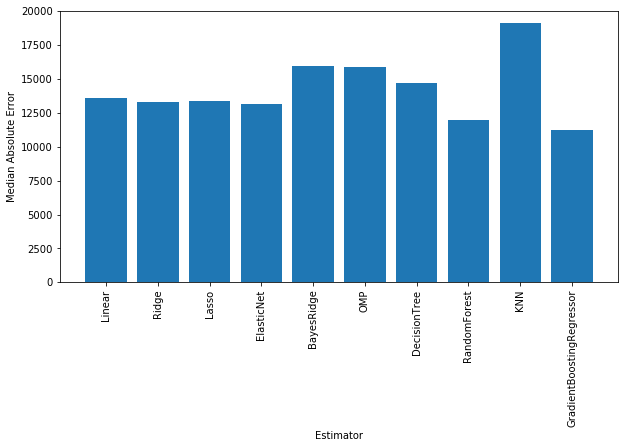

In [99]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors

rs = 1
ests = [ 
    linear_model.LinearRegression(), 
    linear_model.Ridge(),    
    linear_model.Lasso(), 
    linear_model.ElasticNet(),
    linear_model.BayesianRidge(),
    linear_model.OrthogonalMatchingPursuit(),
    tree.DecisionTreeRegressor(max_depth=10),
    ensemble.RandomForestRegressor(),
    neighbors.KNeighborsRegressor(n_neighbors=5),
    ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.01,loss="ls")
]

ests_labels = ['Linear', 
               'Ridge', 
               'Lasso',
               'ElasticNet',
               'BayesRidge',
               'OMP',
               'DecisionTree',
               'RandomForest',
               'KNN',
               'GradientBoostingRegressor']

errvals = []

for e in ests:
    e.fit(X_train, y_train)
    err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals.append(err)


pos = range(len(errvals))
plt.figure(figsize=(10,5))
plt.bar(pos, errvals, align='center')
plt.xticks(pos, ests_labels, rotation = 90)
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')